In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

In [ ]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [ ]:
data = pd.read_csv('./organised_data.csv')
df_imputed = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/organised_data_mean_imput.csv')

In [ ]:
clinical_biochem = pd.read_csv('../Clinical/TB_Portals_Published_Clinical_Data_August_2023/TB_Portals_Biochemistry_August_2023.csv') #blood test measurements
clinical_DST = pd.read_csv('../Clinical/TB_Portals_Published_Clinical_Data_August_2023/TB_Portals_DST_August_2023.csv') # mostly empty
clinical_patient = pd.read_csv('../Clinical/TB_Portals_Published_Clinical_Data_August_2023/TB_Portals_Patient_Cases_August_2023.csv') # body, background, diagnostic detail
clinical_regimens = pd.read_csv('../Clinical/TB_Portals_Published_Clinical_Data_August_2023/TB_Portals_Regimens_August_2023.csv') #outcome. drug regimen, same patient id number as clinical_patient as cases
clinical_specimen = pd.read_csv('../Clinical/TB_Portals_Published_Clinical_Data_August_2023/TB_Portals_Specimen_August_2023.csv') # collection dates and source - no use
clinical_genomics = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Genomic/TB_Portals_Published_Genomics_Data_August_2023/TB_Portals_Sequenced_DST_August_2023.csv') # no use - only DST data
genomics = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Genomic/TB_Portals_Published_Genomics_Data_August_2023/TB_Portals_Genomics_August_2023.csv')

# Data explore

In [ ]:
print('bactec results======')
print(clinical_patient['bactec_test'].value_counts())
print('leresults======')
print(clinical_patient['le_test'].value_counts())
print('lpaotherresults=====')
print(clinical_patient['lpaother_test'].value_counts())
print('hainresults=====')
print(clinical_patient['hain_test'].value_counts())
print('genexpertresults=======')
print(clinical_patient['genexpert_test'].value_counts())

# bactec_test
# le_test
# hain_test
# lpaother_test
# genexpert_test

bactec results======
bactec_test
R, S            4681
Not Reported    3730
S               2349
R                461
I, R, S           48
I, S              11
I                  1
I, R               1
Name: count, dtype: int64
leresults======
le_test
Not Reported    6199
R, S            2628
S               1812
R                557
I, R, S           77
I, R               6
I, S               3
Name: count, dtype: int64
lpaotherresults=====
lpaother_test
Not Reported    9171
S               1269
R, S             685
R                145
I, S               6
I                  3
I, R, S            3
Name: count, dtype: int64
hainresults=====
hain_test
Not Reported    6390
S               2267
R               1567
R, S            1051
I, R               3
I, S               2
I, R, S            1
I                  1
Name: count, dtype: int64
genexpertresults=======
genexpert_test
R               4092
S               3524
Not Reported    3439
R, S             218
I                  7
I, 

In [ ]:
columns_to_check = ['bactec_test', 'le_test', 'hain_test', 'lpaother_test', 'genexpert_test']

# Check if all specified columns have "Not Reported" in each row
not_reported_rows = clinical_patient[columns_to_check].eq('Not Reported').all(axis=1)

# Count the number of such rows
not_reported_count = not_reported_rows.sum()


In [ ]:
import pandas as pd
from collections import Counter

# Ranking of tests
ranking = {
    'genexpert_test': 1,
    'hain_test': 2,
    'lpaother_test': 3,
    'bactec_test': 4,
    'le_test': 5
}

# Function to determine the majority decision based on the rules
def majority_vote(row):
    # Filter out "Not Reported" values
    reported_values = [row[col] for col in row.index if row[col] != 'Not Reported']
    
    # If all values are "Not Reported"
    if not reported_values:
        return 'Not Reported'
    
    # Count the occurrences of each value
    counter = Counter(reported_values)
    most_common = counter.most_common()
    
    # If there's a clear majority
    if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:
        return most_common[0][0]
    
    # If there's a tie, use the ranking to determine the decision
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        # Get the highest ranked value according to the ranking system
        highest_ranked_value = None
        highest_rank = float('inf')
        for value in reported_values:
            for test in ranking:
                if row[test] == value and ranking[test] < highest_rank:
                    highest_ranked_value = value
                    highest_rank = ranking[test]
        return highest_ranked_value

# Apply the function to each row and create a new column for the results
# df['majority_decision'] = df.apply(majority_vote, axis=1)

# print(df)

In [ ]:
clinical_patient_tests = clinical_patient[['bactec_test', 'le_test', 'hain_test', 'lpaother_test', 'genexpert_test']]

In [7]:
clinical_patient = clinical_patient[clinical_patient['majority_decision'] != 'Not Reported']

KeyError: 'majority_decision'

In [89]:
clinical_patient['smallcavities']

0        Lower Left Sextant-No, Lower Right Sextant-No,...
1        Lower Left Sextant-No, Middle Left Sextant-No,...
2        Lower Right Sextant-No, Middle Right Sextant-Y...
3        Middle Left Sextant-No, Upper Left Sextant-Yes...
4        Lower Left Sextant-No, Lower Right Sextant-No,...
                               ...                        
11277    Lower Right Sextant-No, Middle Right Sextant-N...
11278    Middle Left Sextant-No, Upper Left Sextant-No,...
11279    Lower Left Sextant-No, Lower Right Sextant-No,...
11280      Middle Right Sextant-No, Upper Right Sextant-No
11281    Middle Left Sextant-No, Upper Left Sextant-No,...
Name: smallcavities, Length: 11282, dtype: object

In [83]:
# Sample data
data = """
education | Not Reported: | 3976
image_body_site | Not Reported: | 9840
dissemination | Not Reported: | 9836
lungcavity_size | Not Reported: | 9838
anomaly_of_mediastinum_vessels_develop | Not Reported: | 9958
affect_pleura | Not Reported: | 9942
shadow_pattern | Not Reported: | 9860
affect_level | Not Reported: | 9994
pneumothorax | Not Reported: | 9840
plevritis | Not Reported: | 9841
affected_segments | Not Reported: | 9843
nodicalcinatum | Not Reported: | 9840
process_prevalence | Not Reported: | 9841
thromboembolism_of_the_pulmonaryartery | Not Reported: | 9973
posttbresiduals | Not Reported: | 9842
lung_capacity_decrease | Not Reported: | 9838
bronchial_obstruction | Not Reported: | 9964
anomaly_of_lungdevelop | Not Reported: | 9840
accumulation_of_contrast | Not Reported: | 9991
limfoadenopatia | Not Reported: | 9843
totalcavernum | Not Reported: | 9838

overall_percent_of_abnormal_volume | Not Reported: | 3074
pleural_effusion_percent_of_hemithorax_involved | Not Reported: | 3074
ispleuraleffusionbilateral | Not Reported: | 3074
other_non_tb_abnormalities | Not Reported: | 3074
are_mediastinal_lymphnodes_present | Not Reported: | 3074
collapse | Not Reported: | 3081
smallcavities | Not Reported: | 3078
mediumcavities | Not Reported: | 3079
largecavities | Not Reported: | 3081
isanylargecavitybelongtoamultisextantcavity | Not Reported: | 3075
canmultiplecavitiesbeseen | Not Reported: | 3075
infiltrate_lowgroundglassdensity | Not Reported: | 3074
infiltrate_mediumdensity | Not Reported: | 3078
infiltrate_highdensity | Not Reported: | 3079
smallnodules | Not Reported: | 3077
mediumnodules | Not Reported: | 3078
largenodules | Not Reported: | 3082
hugenodules | Not Reported: | 3082
isanycalcifiedorpartiallycalcifiednoduleexist | Not Reported: | 3075
isanynoncalcifiednoduleexist | Not Reported: | 3075
isanyclusterednoduleexists | Not Reported: | 3075
aremultiplenoduleexists | Not Reported: | 3076
lowgroundglassdensityactivefreshnodules | Not Reported: | 3076
mediumdensitystabalizedfibroticnodules | Not Reported: | 3078
highdensitycalcifiedtypicallysequella | Not Reported: | 3082
"""

# Split the data into lines
lines = data.strip().split('\n')

# Extract the first item in each row
first_items = [line.split('|')[0].strip() for line in lines]

# Print the result
for item in first_items:
    print(item)


education
image_body_site
dissemination
lungcavity_size
anomaly_of_mediastinum_vessels_develop
affect_pleura
shadow_pattern
affect_level
pneumothorax
plevritis
affected_segments
nodicalcinatum
process_prevalence
thromboembolism_of_the_pulmonaryartery
posttbresiduals
lung_capacity_decrease
bronchial_obstruction
anomaly_of_lungdevelop
accumulation_of_contrast
limfoadenopatia
totalcavernum
overall_percent_of_abnormal_volume
pleural_effusion_percent_of_hemithorax_involved
ispleuraleffusionbilateral
other_non_tb_abnormalities
are_mediastinal_lymphnodes_present
collapse
smallcavities
mediumcavities
largecavities
isanylargecavitybelongtoamultisextantcavity
canmultiplecavitiesbeseen
infiltrate_lowgroundglassdensity
infiltrate_mediumdensity
infiltrate_highdensity
smallnodules
mediumnodules
largenodules
hugenodules
isanycalcifiedorpartiallycalcifiednoduleexist
isanynoncalcifiednoduleexist
isanyclusterednoduleexists
aremultiplenoduleexists
lowgroundglassdensityactivefreshnodules
mediumdensitystab

## Data gen

In [8]:
import pandas as pd
import numpy as np

def count_yes_and_fill_mean(df, column_name):
    # Step 1: Count 'Yes' in each value of the column and replace the value with that count, ignoring 'Not Reported'
    df[column_name] = df[column_name].apply(lambda x: str(x).count('Yes') if x != 'Not Reported' else np.nan)
    
    # Step 2: Calculate the mean of the non-NaN values (ignoring 'Not Reported')
    mean_value = df[column_name].mean()
    
    # Step 3: Fill 'Not Reported' values with the rounded mean
    df[column_name].fillna(round(mean_value), inplace=True)

    return df

# Example usage
clinical_test = pd.DataFrame({
    'column_with_yes': ['Yes, Yes', 'No', 'Yes', 'Not Reported', 'Yes, Yes, Yes']
})

clinical_test = count_yes_and_fill_mean(clinical_test, 'column_with_yes')

print(clinical_test)

   column_with_yes
0             2.00
1             0.00
2             1.00
3             2.00
4             3.00


In [9]:
lung_features = [
    'condition_id',
    "overall_percent_of_abnormal_volume",
    "pleural_effusion_percent_of_hemithorax_involved",
    "ispleuraleffusionbilateral",
    "other_non_tb_abnormalities",
    "are_mediastinal_lymphnodes_present",
    
    "collapse",
    "smallcavities",
    "mediumcavities",
    "largecavities",
    "isanylargecavitybelongtoamultisextantcavity",
    "canmultiplecavitiesbeseen",
    "infiltrate_lowgroundglassdensity",
    "infiltrate_mediumdensity",
    "infiltrate_highdensity",
    "smallnodules",
    "mediumnodules",
    "largenodules",
    "hugenodules",
    "isanycalcifiedorpartiallycalcifiednoduleexist",
    "isanynoncalcifiednoduleexist",
    "isanyclusterednoduleexists",
    "aremultiplenoduleexists",
    "lowgroundglassdensityactivefreshnodules",
    "mediumdensitystabalizedfibroticnodules",
    "highdensitycalcifiedtypicallysequella"
]


In [10]:
count_features = [
    "collapse",
    "smallcavities",
    "mediumcavities",
    "largecavities",
    "isanylargecavitybelongtoamultisextantcavity",
    "canmultiplecavitiesbeseen",
    "infiltrate_lowgroundglassdensity",
    "infiltrate_mediumdensity",
    "infiltrate_highdensity",
    "smallnodules",
    "mediumnodules",
    "largenodules",
    "hugenodules",
    "isanycalcifiedorpartiallycalcifiednoduleexist",
    "isanynoncalcifiednoduleexist",
    "isanyclusterednoduleexists",
    "aremultiplenoduleexists",
    "lowgroundglassdensityactivefreshnodules",
    "mediumdensitystabalizedfibroticnodules",
    "highdensitycalcifiedtypicallysequella"]

In [11]:
import pandas as pd
import numpy as np
clinical_lung = clinical_patient[lung_features]
def count_yes_and_fill_mean(df, column_name):
    # Step 1: Count 'Yes' in each value of the column and replace the value with that count, ignoring 'Not Reported'
    df[column_name] = df[column_name].apply(lambda x: str(x).count('Yes') if x != 'Not Reported' else np.nan)
    
    # Step 2: Calculate the mean of the non-NaN values (ignoring 'Not Reported')
    mean_value = df[column_name].mean()
    
    # Step 3: Fill 'Not Reported' values with the rounded mean
    df[column_name].fillna(round(mean_value), inplace=True)

    return df

# clinical_lung = count_yes_and_fill_mean(clinical_lung, 'column_with_yes')

for x in count_features:
    clinical_lung = count_yes_and_fill_mean(clinical_lung, x)

In [12]:
clinical_lung['overall_percent_of_abnormal_volume'] = clinical_lung['overall_percent_of_abnormal_volume'].replace({
    'Less than 50': 1,
    'Not reported': 1,
    '0': 0,
    '0, Less than 50': 0,
    'Not Reported': 0,
    'Greater than or equal to 50': 2,
    'Greater than or equal to 50, Less than 50': 2
})
clinical_lung['pleural_effusion_percent_of_hemithorax_involved'] = clinical_lung['pleural_effusion_percent_of_hemithorax_involved'].replace({
    'Less than 50': 1,
    'Not reported': 1,
    '0': 0,
    '0, Less than 50': 0,
    'Not Reported': 0,
    'Greater than or equal to 50': 2,
    'Greater than or equal to 50, Less than 50': 2
})
clinical_lung['ispleuraleffusionbilateral'] = clinical_lung['ispleuraleffusionbilateral'].replace({
    'No': 0,
    'Not Reported': 0,
    'Yes': 1,
    'No, Yes' : 1
})
clinical_lung['other_non_tb_abnormalities'] = clinical_lung['other_non_tb_abnormalities'].replace({
    'No': 0,
    'Not Reported': 0,
    'Yes': 1,
    'No, Yes' : 1
})
clinical_lung['are_mediastinal_lymphnodes_present'] = clinical_lung['are_mediastinal_lymphnodes_present'].replace({
    'No': 0,
    'Not Reported': 0,
    'Yes': 1,
    'No, Yes' : 1
})


In [13]:
clinical_lung['ispleuraleffusionbilateral'].value_counts()

ispleuraleffusionbilateral
0.00    11165
1.00      111
Name: count, dtype: int64

In [14]:
dropped_col = []
for x in clinical_patient.columns:
    # print('===============')
    if 'Not Reported' in clinical_patient[x].value_counts().keys():
        print(x,'|', 'Not Reported:','|', clinical_patient[x].value_counts()['Not Reported'])
        # print(clinical_patient[x].value_counts())
        dropped_col.append(x)

education | Not Reported: | 4017
employment | Not Reported: | 923
diagnosis_code | Not Reported: | 1
image_body_site | Not Reported: | 9903
dissemination | Not Reported: | 9899
lungcavity_size | Not Reported: | 9901
anomaly_of_mediastinum_vessels_develop | Not Reported: | 10021
affect_pleura | Not Reported: | 10005
shadow_pattern | Not Reported: | 9923
affect_level | Not Reported: | 10064
pneumothorax | Not Reported: | 9903
plevritis | Not Reported: | 9904
affected_segments | Not Reported: | 9906
nodicalcinatum | Not Reported: | 9903
process_prevalence | Not Reported: | 9904
thromboembolism_of_the_pulmonaryartery | Not Reported: | 10039
posttbresiduals | Not Reported: | 9905
lung_capacity_decrease | Not Reported: | 9901
bronchial_obstruction | Not Reported: | 10027
anomaly_of_lungdevelop | Not Reported: | 9903
accumulation_of_contrast | Not Reported: | 10057
limfoadenopatia | Not Reported: | 9906
totalcavernum | Not Reported: | 9901
overall_percent_of_abnormal_volume | Not Reported: | 

In [15]:

def plot_feature_importance(importances, feature_names, title):
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 17))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [16]:
clinical_biochem = clinical_biochem.drop_duplicates(subset='condition_id', keep=False)

In [17]:
Clinical_data = pd.merge(clinical_patient, clinical_biochem, on='condition_id', how='left')

variables = [
    "condition_id",
    "Total Protein (g/l)",
    "Aspartate Aminotransferase (u/l)",
    "Hepatitis B Surface Antigen",
    "Hepatitis C Virus",
    "Glucose: Diabetic Post-Meal (mmol/l)",
    # "Bilirubin",
    "Albumin (g/l)",
    "Urea (mmol/l)",
    "Total Bilirubin (umol/l)",
    "Alanine Aminotransferase (u/l)",
    "Erythrocyte Sedimentation Rate (mm/hr)",
    "C-Reactive Protein (mg/l)",
    "Hemoglobin (g/l)",
    "Hemoglobin A1c (%)",
    "Fasting Blood Sugar (Glucose) (mmol/l)",
    "Adenosine Deaminase (u/l)",
    "Absolute Neutrophil Count",
    "Absolute Lymphocyte Count",
    # "Neutrophil-lymphocyte ratio"
]

Clinical_data = Clinical_data[['outcome','age_of_onset','gender','country','employment','number_of_children','number_of_daily_contacts','case_definition','type_of_resistance','bmi','lung_localization']+variables]
Clinical_data = Clinical_data[~Clinical_data['outcome'].isin(['Lost to follow up', 'Unknown', 'Still on treatment','Completed'])]
Clinical_data['outcome'].replace({'Cured': 1, 'Died': 0, 'Failure': 0, 'Palliative Care': 0}, inplace=True)

In [18]:
genomics_ =  genomics[['condition_id','main_lineage']]
Clinical_data = pd.merge(Clinical_data, genomics_, on='condition_id', how='left')
Clinical_data = pd.merge(Clinical_data, clinical_lung, on='condition_id', how='left')

In [19]:
def Label_encoding(employment_data, input, missing=False):
    # Initialize the LabelEncoder
    if missing:
        employment_data = employment_data + [missing]
        input.fillna(missing, inplace=True)

    label_encoder = LabelEncoder()

    label_encoder.fit(employment_data)
    output = label_encoder.transform(input)
    # Replace np.nan with a placeholder, for example, 'Missing'
    missing_ind = len(employment_data)-1
    output1 = []
    if missing:
        # output = [x if x == missing_ind else np.NaN for x in output]
        for x in output:
            if x == missing_ind or pd.isna(x):
                output1.append(np.nan)
            else:
                output1.append(x)
        output = output1
    # Fit and transform the data
    return output

In [20]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Clinical_data['gender'] = label_encoder.fit_transform(Clinical_data['gender'].values)
Clinical_data['country'] = label_encoder.fit_transform(Clinical_data['country'].values)

Clinical_data['employment'] = Label_encoding(['Disabled','Retired','Unofficially employed','Unemployed','Student','Homemaker','Employed','Self-employed','Not Reported'], Clinical_data['employment'], np.nan)

Clinical_data['type_of_resistance'].replace('Negative','Sensitive', inplace=True)
Clinical_data['type_of_resistance'] = Label_encoding(['Sensitive', 'Mono DR', 'Poly DR', 'MDR non XDR', 'Pre-XDR','XDR'], Clinical_data['type_of_resistance'], np.nan)

Clinical_data['lung_localization'] = Label_encoding(['Pulmonary', 'Pulmonary and Extrapulmonary', 'Extrapulmonary'], Clinical_data['lung_localization'], 'Unknown')

# number_of_children
Clinical_data['number_of_children'].replace('>10', 11, inplace=True)
Clinical_data['number_of_children'].replace('unknown', np.nan, inplace=True)
Clinical_data['number_of_children'] = Clinical_data['number_of_children'].astype(float)

# number_of_daily_contacts
Clinical_data['number_of_daily_contacts'].replace('>10', 11, inplace=True)
Clinical_data['number_of_daily_contacts'] = Clinical_data['number_of_daily_contacts'].astype(float)

# Fill in missing values with the mean
# Fill in missing values with the mean
mean_number_of_children = Clinical_data['number_of_children'].mean()
mean_number_of_daily_contacts = Clinical_data['number_of_daily_contacts'].mean()
# mean_potassium = Clinical_data['Potassium (mmol/l)'].mean()
# mean_gloucose = Clinical_data['Glucose (mmol/l)'].mean()
# mean_creainine = Clinical_data['Creatinine (umol/l)'].mean()
mean_total_protein = Clinical_data['Total Protein (g/l)'].mean()
mean_aspartate_aminotransferase = Clinical_data['Aspartate Aminotransferase (u/l)'].mean()
mean_total_bilirubin = Clinical_data['Total Bilirubin (umol/l)'].mean()
mean_alanine_aminotransferase = Clinical_data['Alanine Aminotransferase (u/l)'].mean()
mean_bmi = Clinical_data['bmi'].mean()

Clinical_data['number_of_children'].fillna(mean_number_of_children, inplace=True)
Clinical_data['number_of_daily_contacts'].fillna(mean_number_of_daily_contacts, inplace=True)
# Clinical_data['Potassium (mmol/l)'].fillna(mean_potassium, inplace=True)
# Clinical_data['Glucose (mmol/l)'].fillna(mean_gloucose, inplace=True)
# Clinical_data['Creatinine (umol/l)'].fillna(mean_creainine, inplace=True)
Clinical_data['Total Protein (g/l)'].fillna(Clinical_data['Total Protein (g/l)'].mean(), inplace=True)
Clinical_data['Aspartate Aminotransferase (u/l)'].fillna(Clinical_data['Aspartate Aminotransferase (u/l)'].mean(), inplace=True)
Clinical_data['Total Bilirubin (umol/l)'].fillna(Clinical_data['Total Bilirubin (umol/l)'].mean(), inplace=True)
Clinical_data['Alanine Aminotransferase (u/l)'].fillna(Clinical_data['Alanine Aminotransferase (u/l)'].mean(), inplace=True)
Clinical_data['bmi'].fillna(Clinical_data['bmi'].mean(), inplace=True)

Clinical_data['case_definition'] = Clinical_data['case_definition'].replace(['Lost to follow up', 'Other'], 'Unknown')
Clinical_data['case_definition'] = Label_encoding(['Failure','Relapse', 'Chronic TB',  'New', 'Unknown'], Clinical_data['case_definition'])
Clinical_data['Hepatitis B Surface Antigen'] = Label_encoding(['Negative (-)', 'Positive (+)'], Clinical_data['Hepatitis B Surface Antigen'], 'Not Reported')
Clinical_data['Hepatitis C Virus'] = Label_encoding(['Negative (-)', 'Positive (+)'], Clinical_data['Hepatitis C Virus'], 'Not Reported')


In [ ]:
to_drop = ["Glucose: Diabetic Post-Meal (mmol/l)",
"Erythrocyte Sedimentation Rate (mm/hr)",    
"C-Reactive Protein (mg/l)",
"Hemoglobin (g/l)",        
"Hemoglobin A1c (%)",                        
"Fasting Blood Sugar (Glucose) (mmol/l)",
"Adenosine Deaminase (u/l)",
"Absolute Neutrophil Count",               
"Absolute Lymphocyte Count",
"Albumin (g/l)",   
"Urea (mmol/l)",
"condition_id",]       

Clinical_data.drop(to_drop, axis=1, inplace=True)
# Clinical_data = Clinical_data.fillna(Clinical_data.mean())


In [ ]:
def fill_na_with_mean(df):
    # Iterate over each column and fill NaN values with the column mean
    for column in df.columns:
        if df[column].dtype in ['float64', 'int64']:  # Ensure it's a numeric column
            mean_value = df[column].mean()
            df[column].fillna(mean_value, inplace=True)
    return df

Clinical_data_filled = fill_na_with_mean(Clinical_data)
Clinical_data_filled.drop(columns=['condition_id'], inplace=True)   

In [29]:
Clinical_data_filled['main_lineage'] = Clinical_data_filled['main_lineage'].replace({
    'lineage1': 1,
    'lineage2': 2,
    'lineage3': 3,
    'lineage4': 4,
    'lineage2;lineage4' : 5,
    'lineage1;lineage2' : 6,
    'lineage3;lineage4' : 7,
    'La1' : 8,
    'La2' : 9,
})

In [30]:
def fill_na_with_half_2_half_4(df, column_name):
    # Ensure the column exists in the DataFrame
    if column_name in df.columns:
        na_indices = df[df[column_name].isna()].index
        na_count = len(na_indices)
        
        # If there are NaN values, proceed
        if na_count > 0:
            # Split the NaN indices into two halves
            half_point = na_count // 2
            
            # Fill the first half with 2 and the second half with 4
            df.loc[na_indices[:half_point], column_name] = 2
            df.loc[na_indices[half_point:], column_name] = 4
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")
    
    return df
Clinical_data_filled = fill_na_with_half_2_half_4(Clinical_data_filled, 'main_lineage')

In [31]:
def identify_not_reported_columns(df):
    # Create a list to store columns that contain the value 'Not reported'
    not_reported_columns = []
    
    # Iterate over each column and check if 'Not reported' is present
    for column in df.columns:
        if df[column].isin(['Not Reported']).any():
            not_reported_columns.append(column)
    
    return not_reported_columns
print(identify_not_reported_columns(Clinical_data_filled))

[]


### Lazypredict

In [196]:
from sklearn.preprocessing import StandardScaler
Clinical_data = Clinical_data_filled
scaler = StandardScaler()
normalized_data = scaler.fit_transform(Clinical_data)

# Create a DataFrame from the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=Clinical_data.columns)
print("Normalized DataFrame:")
print(normalized_df)

Normalized DataFrame:
      outcome  age_of_onset  gender  country  employment  number_of_children   
0        0.57         -0.21    0.60    -0.80        0.75                0.00  \
1        0.57         -0.99    0.60    -0.80       -1.43                0.00   
2        0.57         -1.41   -1.68    -0.80        0.75                0.00   
3        0.57          1.21    0.60    -0.80        0.75                0.00   
4       -1.75          0.36    0.60     0.62       -1.43                0.00   
...       ...           ...     ...      ...         ...                 ...   
8311     0.57         -1.41    0.60    -0.80        0.75                0.00   
8312    -1.75          0.36    0.60     1.32        0.75                0.00   
8313     0.57         -0.42    0.60     1.32        0.75                0.00   
8314    -1.75          0.08    0.60     1.32        0.75                1.79   
8315    -1.75          1.56    0.60     1.32       -0.34                0.00   

      number_of_d

In [197]:
variance = normalized_df.var()
print("\nVariance of Each Feature:")
print(variance)


Variance of Each Feature:
outcome                                           1.00
age_of_onset                                      1.00
gender                                            1.00
country                                           1.00
employment                                        1.00
number_of_children                                1.00
number_of_daily_contacts                          1.00
case_definition                                   1.00
type_of_resistance                                1.00
bmi                                               1.00
lung_localization                                 1.00
Total Protein (g/l)                               1.00
Aspartate Aminotransferase (u/l)                  1.00
Hepatitis B Surface Antigen                       1.00
Hepatitis C Virus                                 1.00
Total Bilirubin (umol/l)                          1.00
Alanine Aminotransferase (u/l)                    1.00
main_lineage                          

In [32]:
X = Clinical_data.drop('outcome', axis=1)
y = Clinical_data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [01:02<00:00,  1.12it/s]

[LightGBM] [Info] Number of positive: 5013, number of negative: 1639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1481
[LightGBM] [Info] Number of data points in the train set: 6652, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753608 -> initscore=1.117948
[LightGBM] [Info] Start training from score 1.117948


100%|██████████| 29/29 [01:02<00:00,  2.17s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
BaggingClassifier                  0.78               0.68     0.68      0.77  \
LGBMClassifier                     0.80               0.67     0.67      0.79   
XGBClassifier                      0.80               0.67     0.67      0.78   
NearestCentroid                    0.71               0.66     0.66      0.72   
AdaBoostClassifier                 0.80               0.65     0.65      0.78   
ExtraTreesClassifier               0.80               0.65     0.65      0.78   
RandomForestClassifier             0.80               0.65     0.65      0.78   
DecisionTreeClassifier             0.72               0.63     0.63      0.72   
QuadraticDiscriminantAnalysis      0.75               0.62     0.62      0.74   
BernoulliNB                        0.73               0.62     0.62      0.73   
LabelPropagation            

### TabPFN

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from tabpfn import TabPFNClassifier

X = Clinical_data.drop('outcome', axis=1)
y = Clinical_data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=32)

classifier.fit(X_train, y_train,  overwrite_warning=True)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

auc = roc_auc_score(y_test, y_eval)
print("AUC:", auc)

# Calculate confusion matrix components
conf_matrix = confusion_matrix(y_test, y_eval)
print("Confusion Matrix:\n", conf_matrix)
tn, fp, fn, tp = confusion_matrix(y_test, y_eval).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

AUC: 0.6166024818142919
Confusion Matrix:
 [[ 110  300]
 [  44 1210]]
Sensitivity: 0.9649122807017544
Specificity: 0.2682926829268293


### lgb

In [ ]:
Clinical_data.columns = [col.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').replace(':', '') for col in Clinical_data.columns]
X = Clinical_data.drop('outcome', axis=1)
y = Clinical_data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

LightGBM Accuracy: 0.8058894230769231
LightGBM Feature Importances: [378  38 123 108  92 118 111 145 347  18 143 173   9  25 155 152  48  62
  10   4   8  30  19  41  34  22  22  13  63  64  17  62  60  26   8  35
  45  22  39  51  41  19]
LightGBM Feature Importances: [378  38 123 108  92 118 111 145 347  18 143 173   9  25 155 152  48  62
  10   4   8  30  19  41  34  22  22  13  63  64  17  62  60  26   8  35
  45  22  39  51  41  19]


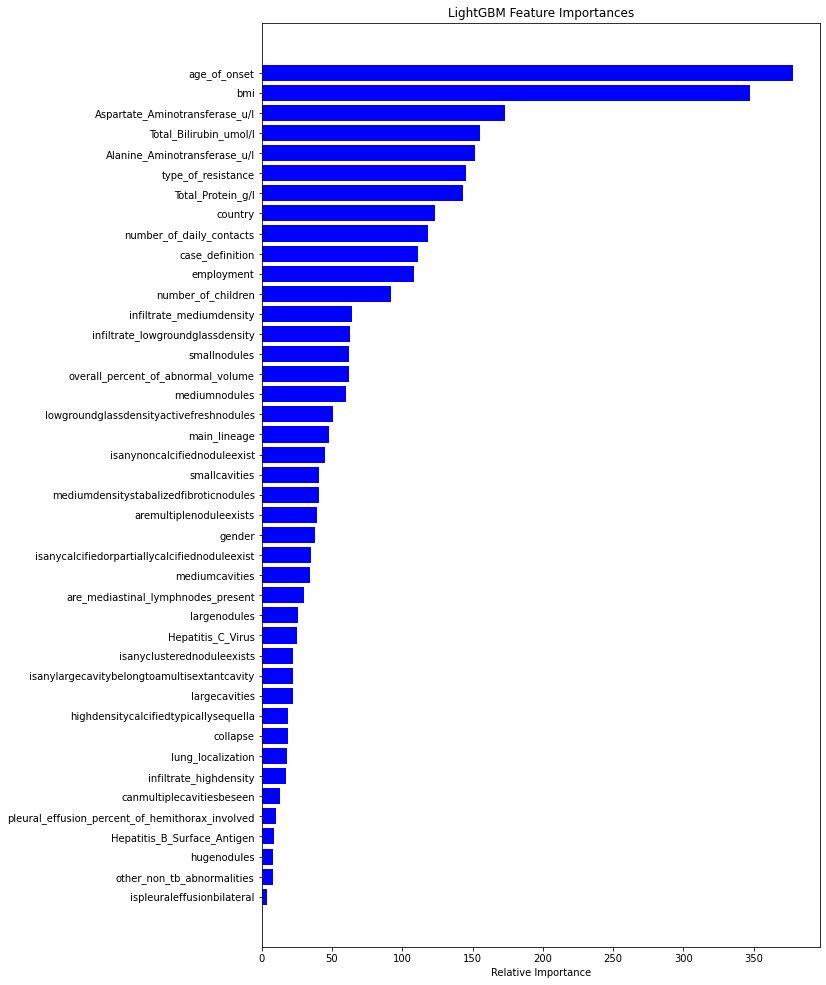

In [ ]:
import lightgbm as lgb 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

lgb_clf = lgb.LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, verbose = -1)
lgb_clf.fit(X_train, y_train)
lgb_predictions = lgb_clf.predict(X_test)
print(f'LightGBM Accuracy: {accuracy_score(y_test, lgb_predictions)}')

lgb_feature_importances = lgb_clf.feature_importances_
print(f'LightGBM Feature Importances: {lgb_feature_importances}')
# plot_feature_importance(lgb_feature_importances, feature_names, 'LightGBM Feature Importances')




import matplotlib.pyplot as plt
import numpy as np

# Assuming the feature names are available in a list called feature_names
feature_names = X.columns  # Example, if using a dataset like Iris from sklearn

# Function to plot feature importance

# LightGBM Feature Importance
lgb_feature_importances = lgb_clf.feature_importances_
print(f'LightGBM Feature Importances: {lgb_feature_importances}')
plot_feature_importance(lgb_feature_importances, feature_names, 'LightGBM Feature Importances')


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


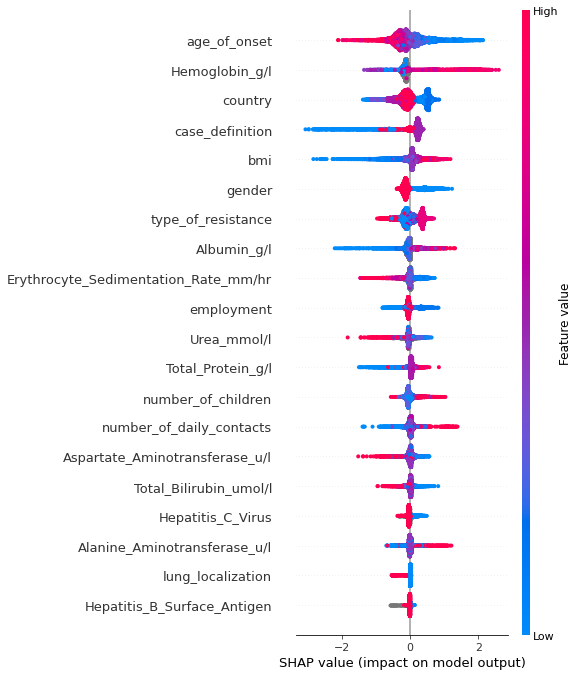

In [ ]:
import shap
# Assuming Clinical_data is a pandas DataFrame with the necessary data
X = Clinical_data.drop('outcome', axis=1)
y = Clinical_data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
lgb_clf = lgb.LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, verbose = -1)
lgb_clf.fit(X_train, y_train)
explainer = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(X_train)
# For classification, shap_values returns a list of arrays (one for each class)
# Use the shap values for the class of interest (here, assuming binary classification)
shap.summary_plot(shap_values[1], X_train)

### catboost

In [ ]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming Clinical_data is already defined and loaded

# Prepare the data
X = Clinical_data.drop('outcome', axis=1)
y = Clinical_data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the CatBoostClassifier
model = cb.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Feature importance
importances = model.get_feature_importance()
feature_names = X.columns
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### model parameter grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Create a parameter grid for each model
param_grid_lgbm = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_extra_trees = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_bagging = {
    'n_estimators': [10, 50],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

param_grid_catboost = {
    'iterations': [100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize the models
lgbm = lgb.LGBMClassifier()
rf = RandomForestClassifier()
extra_trees = ExtraTreesClassifier()
bagging = BaggingClassifier(base_estimator=RandomForestClassifier())
catboost = CatBoostClassifier(silent=True)

# Perform grid search for each model
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, cv=3, scoring='accuracy')
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='accuracy')
grid_extra_trees = GridSearchCV(estimator=extra_trees, param_grid=param_grid_extra_trees, cv=3, scoring='accuracy')
grid_bagging = GridSearchCV(estimator=bagging, param_grid=param_grid_bagging, cv=3, scoring='accuracy')
grid_catboost = GridSearchCV(estimator=catboost, param_grid=param_grid_catboost, cv=3, scoring='accuracy')

# Fit the models to the data
X_train, y_train = ...  # Replace with your training data
grid_lgbm.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_extra_trees.fit(X_train, y_train)
grid_bagging.fit(X_train, y_train)
grid_catboost.fit(X_train, y_train)

# Print the best parameters and scores for each model
print("Best parameters for LGBM: ", grid_lgbm.best_params_)
print("Best score for LGBM: ", grid_lgbm.best_score_)

print("Best parameters for RF: ", grid_rf.best_params_)
print("Best score for RF: ", grid_rf.best_score_)

print("Best parameters for Extra Trees: ", grid_extra_trees.best_params_)
print("Best score for Extra Trees: ", grid_extra_trees.best_score_)

print("Best parameters for Bagging: ", grid_bagging.best_params_)
print("Best score for Bagging: ", grid_bagging.best_score_)

print("Best parameters for CatBoost: ", grid_catboost.best_params_)
print("Best score for CatBoost: ", grid_catboost.best_score_)


### emsemble

In [26]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score


# Define the classifiers
classifiers = [
    ('hist_gb', HistGradientBoostingClassifier(random_state=42)),
    # ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', verbose=-1)),
    ('lgbm', LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, random_state=42, verbose=-1)),
    ('rf', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', RandomForestClassifier(random_state=42))
    ])),
    # ('ada', Pipeline([
    #     ('imputer', SimpleImputer(strategy='mean')),
    #     ('clf', AdaBoostClassifier(random_state=42))
    # ])),
    ('et', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', ExtraTreesClassifier(random_state=42))
    ])),
    ('bagging', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', BaggingClassifier(random_state=42))
    ])),
    # ('lr', Pipeline([
    #     ('imputer', SimpleImputer(strategy='mean')),
    #     ('lr', LogisticRegression(random_state=42))
    # ]))
    # ('ls', Pipeline([
    #     ('imputer', SimpleImputer(strategy='mean')),
    #     ('clf',LabelSpreading())
    # # ])),
    # ('lp', Pipeline([
    #     ('imputer', SimpleImputer(strategy='mean')),
    #     ('clf',LabelPropagation())
    # ])),
    # ('knn', Pipeline([
    #     ('imputer', SimpleImputer(strategy='mean')),
    #     ('clf', KNeighborsClassifier())
    # ])),
    # ('svc', Pipeline([
    #     ('imputer', SimpleImputer(strategy='mean')),
    #     ('clf', SVC(probability=True, random_state=42))
    # ])),
    # ('pa', Pipeline([
    #     ('imputer', SimpleImputer(strategy='mean')),
    #     ('clf', PassiveAggressiveClassifier(random_state=42))
    # ])),
    # ('bnb', Pipeline([
    #     ('imputer', SimpleImputer(strategy='mean')),
    #     ('clf', BernoulliNB())
    # ]))
]

# Create the VotingClassifier
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

# Train the VotingClassifier
voting_clf.fit(X_train, y_train)

# Predict on the test data
test_predictions = voting_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("VotingClassifier Accuracy:", accuracy)


VotingClassifier Accuracy: 0.8389328063241107


VotingClassifier Accuracy: 0.8389328063241107
Confusion Matrix:
 [[ 215  243]
 [  83 1483]]
Recall: 0.9469987228607918
Specificity: 0.46943231441048033
ROC-AUC Score: 0.8430694284104914


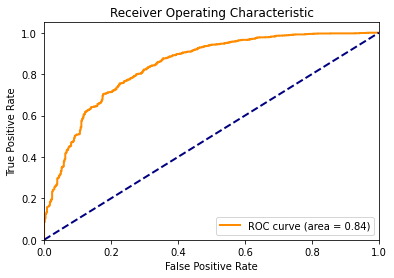

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.47      0.57       458
           1       0.86      0.95      0.90      1566

    accuracy                           0.84      2024
   macro avg       0.79      0.71      0.73      2024
weighted avg       0.83      0.84      0.83      2024



In [27]:
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Train the VotingClassifier
voting_clf.fit(X_train, y_train)

# Predict on the test data
test_predictions = voting_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("VotingClassifier Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Recall
recall = recall_score(y_test, test_predictions)
print("Recall:", recall)

# Specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# ROC-AUC Score
y_test_prob = voting_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_prob)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, test_predictions))

## Weighted

VotingClassifier Accuracy: 0.8389328063241107
Confusion Matrix:
 [[ 215  243]
 [  83 1483]]
Recall: 0.9469987228607918
Specificity: 0.46943231441048033
ROC-AUC Score: 0.8430694284104914


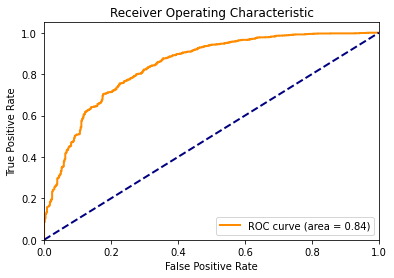

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.47      0.57       458
           1       0.86      0.95      0.90      1566

    accuracy                           0.84      2024
   macro avg       0.79      0.71      0.73      2024
weighted avg       0.83      0.84      0.83      2024



In [37]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define your classifiers
classifiers = [
    ('hist_gb', HistGradientBoostingClassifier(random_state=42)),
    ('lgbm', LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, random_state=42, verbose=-1)),
    ('rf', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', RandomForestClassifier(random_state=42))
    ])),
    ('et', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', ExtraTreesClassifier(random_state=42))
    ])),
    ('bagging', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', BaggingClassifier(random_state=42))
    ]))
]

# Calculate sample weights based on class distribution
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Create a dictionary to store trained classifiers
trained_classifiers = []

# Train each classifier with sample weights
for name, clf in classifiers:
    if isinstance(clf, Pipeline):
        # If classifier is a pipeline, fit it with sample weights
        clf.fit(X_train, y_train, clf__sample_weight=sample_weights)
    else:
        # Otherwise, fit the classifier with sample weights
        clf.fit(X_train, y_train, sample_weight=sample_weights)
    trained_classifiers.append((name, clf))

# Create the VotingClassifier with trained classifiers
voting_clf = VotingClassifier(estimators=trained_classifiers, voting='soft')

# Train the VotingClassifier (sample weights are already applied to individual classifiers)
voting_clf.fit(X_train, y_train)

# Predict on the test data
test_predictions = voting_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("VotingClassifier Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Recall
recall = recall_score(y_test, test_predictions)
print("Recall:", recall)

# Specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# ROC-AUC Score
y_test_prob = voting_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_prob)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, test_predictions))


### lgbm

In [ ]:
class_counts = np.bincount(y_train)
class_weights = class_counts / len(y_train)

In [40]:
np.unique(sample_weights)

array([0.64632588, 2.20851528])

[LightGBM] [Info] Number of positive: 6260, number of negative: 1832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 8092, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.7850790513833992
LightGBM Confusion Matrix:
 [[ 321  137]
 [ 298 1268]]
LightGBM Recall: 0.80970625798212
LightGBM Specificity: 0.7008733624454149
LightGBM Precision: 0.902491103202847
LightGBM F1 Score: 0.853584651632447
LightGBM ROC-AUC Score: 0.8372323724115623


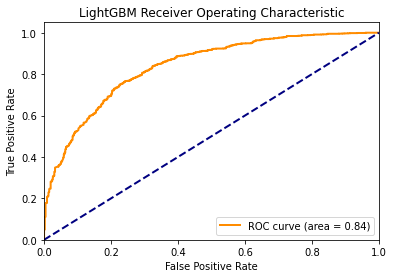

LightGBM Feature Importances: [404  43 136 110  81 159 117 146 449  10 143 176  21  48   3 158 171 158
 164 186   7  94   0   0   0  16   0]


In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, class_weight='balanced', random_state=42)
lgb_clf.fit(X_train, y_train)
lgb_predictions = lgb_clf.predict(X_test)
print(f'LightGBM Accuracy: {accuracy_score(y_test, lgb_predictions)}')

# lgb_feature_importances = lgb_clf.feature_importances_
# print(f'LightGBM Feature Importances: {lgb_feature_importances}')
# plot_feature_importance(lgb_feature_importances, feature_names, 'LightGBM Feature 
# Confusion Matrix for LightGBM
lgb_conf_matrix = confusion_matrix(y_test, lgb_predictions)
print("LightGBM Confusion Matrix:\n", lgb_conf_matrix)

# Recall for LightGBM
lgb_recall = recall_score(y_test, lgb_predictions)
print("LightGBM Recall:", lgb_recall)

# Specificity for LightGBM
lgb_tn, lgb_fp, lgb_fn, lgb_tp = lgb_conf_matrix.ravel()
lgb_specificity = lgb_tn / (lgb_tn + lgb_fp)
print("LightGBM Specificity:", lgb_specificity)

# Precision for LightGBM
lgb_precision = precision_score(y_test, lgb_predictions)
print("LightGBM Precision:", lgb_precision)

# F1 Score for LightGBM
lgb_f1 = f1_score(y_test, lgb_predictions)
print("LightGBM F1 Score:", lgb_f1)

# ROC-AUC Score for LightGBM
lgb_y_test_prob = lgb_clf.predict_proba(X_test)[:, 1]
lgb_roc_auc = roc_auc_score(y_test, lgb_y_test_prob)
print("LightGBM ROC-AUC Score:", lgb_roc_auc)

# ROC Curve for LightGBM
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_y_test_prob)
lgb_roc_auc_value = auc(lgb_fpr, lgb_tpr)

plt.figure()
plt.plot(lgb_fpr, lgb_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % lgb_roc_auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importances for LightGBM
lgb_feature_importances = lgb_clf.feature_importances_
print(f'LightGBM Feature Importances: {lgb_feature_importances}')
# Assuming feature_names is defined
# plot_feature_importance(lgb_feature_importances, feature_names, 'LightGBM Feature Importances')

## Feature selection

### rf

In [204]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Function to evaluate RFE with different numbers of features
def evaluate_rfe(n_features_to_select):
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
    rfe = rfe.fit(X_train, y_train)
    cv_scores = cross_val_score(rfe, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    selected_features = X_train.columns[rfe.support_]
    model.fit(X_train[selected_features], y_train)
    test_score = model.score(X_test[selected_features], y_test)
    return mean_cv_score, test_score, n_features_to_select, selected_features

# Test different numbers of features
feature_range = range(5, 78, 5)  # Testing from 5 to 75 features in steps of 5
results = []

for n_features in feature_range:
    mean_cv_score, test_score, n_features, selected_features = evaluate_rfe(n_features)
    results.append((n_features, mean_cv_score, test_score, selected_features))
    print(f"Features: {n_features}, CV Score: {mean_cv_score}, Test Score: {test_score}")
    print(f"Selected Features: {list(selected_features)}")

# Find the best number of features based on cross-validation score
best_result = max(results, key=lambda x: x[1])
print(f"\nBest result: Features: {best_result[0]}, CV Score: {best_result[1]}, Test Score: {best_result[2]}")
print(f"Selected Features: {list(best_result[3])}")

# Optionally, you can train the final model with the optimal number of features
best_n_features = best_result[0]
_, _, _, selected_features = evaluate_rfe(best_n_features)
model.fit(X_train[selected_features], y_train)
final_test_score = model.score(X_test[selected_features], y_test)
print(f"Final Test set score with {best_n_features} features: {final_test_score}")


Features: 5, CV Score: 0.7539083621902238, Test Score: 0.7866586538461539
Selected Features: ['age_of_onset', 'country', 'bmi', 'Total_Protein_g/l', 'Aspartate_Aminotransferase_u/l']
Features: 10, CV Score: 0.7940460844071109, Test Score: 0.7992788461538461
Selected Features: ['age_of_onset', 'country', 'number_of_daily_contacts', 'case_definition', 'type_of_resistance', 'bmi', 'Total_Protein_g/l', 'Aspartate_Aminotransferase_u/l', 'Alanine_Aminotransferase_u/l', 'smallnodules']
Features: 15, CV Score: 0.796750930670026, Test Score: 0.8173076923076923
Selected Features: ['age_of_onset', 'country', 'employment', 'number_of_daily_contacts', 'case_definition', 'type_of_resistance', 'bmi', 'Total_Protein_g/l', 'Aspartate_Aminotransferase_u/l', 'Total_Bilirubin_umol/l', 'Alanine_Aminotransferase_u/l', 'infiltrate_lowgroundglassdensity', 'smallnodules', 'mediumnodules', 'mediumdensitystabalizedfibroticnodules']
Features: 20, CV Score: 0.7969025493862378, Test Score: 0.8203125
Selected Featur